## Análise de Pontos de Interesse (POIs) e Rede Roteável com OSMnx e Pandana

*TO DO: Aceita caminhada, por ora. Incorporar modos motorizados*

**AUTORIA:** [REDE MOB](https://www.redemob.com.br/), a partir de [um repositório no GitHub](https://github.com/eemilhaa/walkability-analysis).

Com uma combinação de OSMnx e Pandana, cria uma rede roteável e associa localizações de pontos de interesse (POIs) a esta rede. Para esta parte da análise, permite utilizar tanto o grafo completo quanto o grafo simplificado — distinção pode ser encontrada [aqui](https://osmnx.readthedocs.io/en/stable/getting-started.html#). Contudo, **manter a geometria precisa leva a cálculos mais exatos do tempo de viagem**.

Após a construção da rede, a análise de roteamento é feita com o Pandana. Essa análise calcula o tempo de viagem a partir de cada nó da rede até um número especificado de POIs mais próximos. Por exemplo, se for selecionado que é preciso calcular o tempo até os 10 POIs mais próximos, no resultado, cada nó da rede possuirá no máximo 10 valores diferentes de tempo de viagem: tempo até o 1º, 2º, 3º ... 10º POI mais próximo. Tudo isso é sujeito a um tempo máximo de viagem definido pelo usuário. Por exemplo, se o tempo máximo for definido em 15 minutos, locais mais distantes que esse limite são entendidos como fora de alcance.

Os tempos de viagem são calculados a partir da velocidade média de caminhada de uma pessoa.

**PANORAMA:**
- #TODO: Resumir as análises aqui contidas em bullet points

**MAIS INFORMAÇÕES:**
- [Layout da Plataforma]
- [Sumário dos Dados Disponíveis]
- *Lorem ipsum: Conteúdo do MOB de interesse, técnico ou de divulgação*

**LINKS DE INTERESSE:**
- links para materiais técnicos e acadêmicos gerais, externos, de referência a respeito do conteúdo abordado


# Instruções

Este script requer:
1. O código do IBGE para o município
    - Caso se deseje fazer a análise de municípios vizinhos, fornecer uma lista com os códigos do IBGE destes municípios
3. Uma tabela geográfica com a localização dos pontos de interesse: pressupõe-se um arquivo geográfico de pontos ou com polígonos
    - A Plataforma contém uma lista de tabelas com localização de pontos de interesse que correspondem a equipamentos públicos
    - Para dados de saúde e educação, em vez da tabela pode-se apenas escrever `saude` ou `educacao` no parâmetro correspondente
    - Se selecionado `educacao`, é possível selecionar o nível de ensino:
        - Educação Infantil: `infantil`
        - Ensino Fundamental: `fundamental`
        - Ensino Médio: `medio`
        - Educação de Jovens Adultos: `eja`
        - Educação Profissional: `profissional`
        - Combinação dos níveis acima: lista com combinação dos strings acima
   - Se selecionado `educacao`, ainda é possível selecionar se apenas escolas públicas ou privadas:
        - Escolas privadas: `privada`
        - Escolas públicas: `publica`
    - **TO DO: ajustar para complexidade do atendimento a saúde** 

O script apresenta as configurações padrão abaixo, mas os parâmetros correspondentes, na célula abaixo, podem ser alterados de acordo com as necessidades de cada usuário deste script.
- Os tempos de viagem são baseados na suposição de que a velocidade média de caminhada é de 4,5 km/h (1,25 m/s), que corresponde aproximadamente à [velocidade usual de caminhada de adultos aparentemente saudáveis](https://doi.org/10.1007/s40279-020-01351-3). 
- O tempo máximo de viagem é de 60 minutos, ou seja, locais mais distantes são considerados como fora de alcance
- Calcula-se a distância até o POI mais próximo, mas a análise pode considerar um número maior.

# Parâmetros Definidos Pelo Usuário

In [ ]:
# Forneça código do IBGE da cidade, ou lista de códigos
# se quiser cidades vizinhas. P. ex.:
# ibge_id = 3106200 -> Belo Horizonte
# ibge_id = [3106200, 3118601] -> Belo Horizonte e Contagem

ibge_id = [3300704]

# Para estabelecimentos de ensino: poi_type = 'escolas'
# Opcionalmente: nivel_ensino = 'fundamental', 'medio' etc...
# Para atendimento a saúde: poi_type = 'saude'
# Para outros pontos de interesse, poi_type recebe a tabela desejada do repositório do RODA.
poi_type = 'saude'
nivel_ensino = None # Todos os níveis; trocar pelo nível desejado (só útil se poi_type = 'educacao')
categoria_escola = 'publica'

vinculo_sus = True
complexidade = None

velocidade_caminhada = 4.5 # km/h
tempo_maximo_viagem = 30 # minutos (ignora pontos mais longe que isso)
quantidade_pois = 10 # TO DO: pensar em descrição sucinta desse parâmetro

from getpass import getpass
gcloud_id = getpass('Chave do serviço de nuvem do Google:')


Chave do serviço de nuvem do Google: ········


# Backend

Processamento interno do código. A princípio, o usuário não precisa se preocupar com esta parte, mas aqueles com conhecimento mais avançado de programação podem fazer ajustes de acordo com as próprias necessidades específicas.

## Bibliotecas

In [2]:
import basedosdados as bd
import geobr
import osmnx as ox
import pandana
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from unidecode import unidecode

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Área de Estudo

In [3]:
def get_study_area(ibge_id):
    if not isinstance(ibge_id, list):
        ibge_id = [ibge_id]

    return pd.concat([
        geobr.read_municipality(id_)
        for id_
        in ibge_id
        ]).reindex(columns=['geometry'])


place = get_study_area(ibge_id)

In [4]:
crs = place.estimate_utm_crs(datum_name='SIRGAS 2000')
crs

<Projected CRS: EPSG:31983>
Name: SIRGAS 2000 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - between 48°W and 42°W, northern and southern hemispheres, onshore and offshore.
- bounds: (-48.0, -33.5, -42.0, 5.13)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## Pontos de Interesse

In [5]:
def get_pois(
        poi_type,
        place,
        selected_levels=None,
        admin_category=None,
        ):
    if poi_type == 'educacao':
        return _get_schools(place, selected_levels, admin_category)

    if poi_type == 'saude':
        return _get_health(place)

    return poi_type

### Extração e Tratamento de Escolas

In [ ]:
def _filter_by_education_level(schools, selected_levels):
    level_dict = {
        'infantil': 'Educação Infantil',
        'fundamental': 'Ensino Fundamental',
        'medio': 'Ensino Médio',
        'eja': 'Educação de Jovens Adultos',
        'profissional': 'Educação Profissional',
        }
    regex = '|'.join(level_dict.get(k) for k in selected_levels)
    return schools.loc[
        schools.education_level.str.contains(regex, case=False, na=False)
        ]


def _filter_public_schools(school, category):
    gdf = school.assign(
        admin_category=lambda x: [
            unidecode(s)
            for s
            in x.admin_category.str.lower()
            ]
        )

    cat = unidecode(category.lower())
    
    if cat not in {'publica', 'privada'}:
        raise ValueError(
            f"Categoria inválida': {category}'. Use 'publica', 'privada' ou None"
            )
    
    return gdf.loc[gdf['admin_category'] == cat]


def _get_schools(place, selected_levels=None, admin_category=None):
    schools = (
        geobr
        .read_schools(year=2023)
        .sjoin(place)
        .drop(columns='index_right')
        )
    
    if selected_levels:
        schools = _filter_by_education_level(schools, selected_levels)

    if admin_category:
        schools = _filter_public_schools(schools, admin_category)

    return schools

### Extração dos Estabelecimentos de Saúde

In [7]:
def _get_health(place):
    health = (
        geobr
        .read_health_facilities()
        .sjoin(place)
        .drop(columns='index_right')
        .astype({'code_cnes': 'Int64'})
        .astype({'code_cnes': str})
        )

    return health

### Dados do CNES

In [8]:
# A ser usaado mais a frente para atribuir elementos do CNES aos do geobr,
# como leitos etc., caso poi seja saude
def _sql_style_list(sequence):
    single_quoted_elements = [f"'{c}'" for c in sequence]
    return ', '.join(single_quoted_elements)

query = (
    f"SELECT * "
    "FROM basedosdados.br_ms_cnes.estabelecimento "
    f"WHERE id_municipio IN ({_sql_style_list(ibge_id)}) "
    "AND ano = 2024 "
    "AND mes = 9"
    )

Estabelecimentos são filtrados de acordo com o código do tipo de unidade (coluna `tipo_unidade`). Essa análise dos [tipos de estabelecimento](https://cnes2.datasus.gov.br/Mod_Ind_Unidade.asp?VEstado=12) se deu de forma a eliminar aqueles que não fazem parte do escopo desta análise, quais sejam:
- **Instituições não voltadas à saúde humana direta**: como unidades de zoonoses ou veterinárias.
- **Unidades de caráter judicial ou penal**: presídios, penitenciárias, casas de custódia, estabelecimentos vinculados ao sistema prisional ou judiciário.
- **Serviços de saúde mental ou reabilitação social**: CAPS (Centros de Atenção Psicossocial), comunidades terapêuticas, unidades para dependência química.
- **Serviços administrativos ou de apoio**: centrais de regulação, farmácias, unidades de telessaúde, distribuição de órgãos.
- **Unidades militares ou vinculadas à segurança pública**: estabelecimentos militares, da polícia, ou cadeias públicas.
- **Unidades móveis ou comunitárias com escopo limitado**: unidades móveis (não hospitalares), academias da saúde, ou UBS localizadas em contextos não convencionais (como unidades prisionais).

Essa filtragem visa manter apenas os estabelecimentos diretamente relacionados à prestação de serviços clínicos de diferentes níveis de complexidade à população.

In [9]:
units_to_keep = {
    "1": "Hospital Geral",
    "2": "Hospital Especializado",
    "3": "Hospital-Dia",
    "4": "Unidade Mista",
    "5": "Unidade Básica de Saúde",
    "6": "Posto de Saúde",
    "7": "Centro de Saúde/Unidade Básica",
    "8": "Policlínica",
    "9": "Unidade Móvel Terrestre",
    "10": "Pronto Socorro Geral",
    "11": "Pronto Socorro Especializado",
    "12": "Unidade de Apoio à Diagnose e Terapia",
    "13": "Unidade de Atenção Especializada Ambulatorial",
    "14": "Centro de Parto Normal - Isolado",
    "15": "Centro de Atenção Hemoterapia e Hematologia",
    "16": "Centro de Atenção à Saúde Auditiva",
    "17": "Centro de Especialidades Odontológicas",
    "18": "Centro de Reabilitação",
    "19": "Hospital de Ensino",
    "20": "Unidade de Pronto Atendimento (UPA 24h)",
    "21": "Centro de Saúde Escola",
    }

In [10]:
def classificar_complexidade(row):
    alta_cols = {
        'indicador_gestao_alta_ambulatorial_estadual',
        'indicador_gestao_alta_ambulatorial_municipal',
        'indicador_gestao_alta_hospitalar_estadual',
        'indicador_gestao_alta_hospitalar_municipal'
    }

    media_cols = {
        'indicador_gestao_media_ambulatorial_estadual',
        'indicador_gestao_media_ambulatorial_municipal',
        'indicador_gestao_media_hospitalar_estadual',
        'indicador_gestao_media_hospitalar_municipal'
    }

    basica_cols = {
        'indicador_gestao_basica_ambulatorial_estadual',
        'indicador_gestao_basica_ambulatorial_municipal'
    }

    def has_active(columns):
        return any(row.get(col, 0) == 1 for col in columns)

    if has_active(alta_cols):
        return "alta"
    elif has_active(media_cols):
        return "media"
    elif has_active(basica_cols):
        return "basica"
    else:
        return "nao classificado"


def filtrar_por_complexidade(df, niveis):
    if niveis is None:
        return df
    if isinstance(niveis, str):
        niveis = [niveis]
    niveis = [unidecode(nivel.lower()) for nivel in niveis]
    return df[df['complexidade'].str.lower().isin(niveis)]


Para facilitar a análise e a comunicação com gestores públicos, os dados de infraestrutura dos estabelecimentos de saúde foram agrupados em **6 indicadores principais**, considerando critérios funcionais e estratégicos:

**Leitos**

- **`total_leitos_internacao`**: Soma de leitos clínicos, cirúrgicos e complementares, que representam a capacidade de internação plena.
- **`total_leitos_observacao`**: Leitos de repouso e recuperação, tanto em urgência quanto ambulatório, usados em observação de curta duração.
- **`total_leitos_materno_infantil`**: Leitos dedicados à atenção obstétrica e neonatal, agrupando leitos de pré-parto e recém-nascidos.

**Consultórios e Salas**

- **`total_consultorios`**: Abrange todos os consultórios médicos, não médicos e odontológicos, tanto em ambulatórios quanto unidades de urgência.
- **`total_salas_procedimentos`**: Inclui salas para curativos, pequenas cirurgias, nebulização, imunização e apoio de enfermagem, essenciais para atenção básica e média complexidade.
- **`total_salas_cirurgicas_obstetricas`**: Infraestrutura para cirurgias e partos, reunindo blocos cirúrgicos e obstétricos em uma única métrica de alta complexidade.

Essa agregação visa fornecer uma visão clara da **capacidade instalada dos estabelecimentos**, permitindo uma análise mais rápida de gargalos estruturais e auxiliando na priorização de investimentos públicos.

Para isso, é importante compreender a distinção entre **leitos**, **consultórios** e **salas**

| Termo          | Função Principal                     | Exemplos                                 | Indica Capacidade de...                    |
|----------------|--------------------------------------|------------------------------------------|--------------------------------------------|
| **Leito**      | Acomodação para pacientes             | Leito clínico, leito cirúrgico, neonatal | Internação, observação ou repouso          |
| **Consultório**| Atendimento ambulatorial (consultas)  | Consultório médico, odontológico         | Diagnóstico e atendimento ambulatorial     |
| **Sala**       | Procedimentos e tratamentos médicos   | Sala de curativo, cirurgia, parto        | Realização de procedimentos e intervenções |

- **Leito** refere-se à infraestrutura física onde o paciente permanece para repouso, observação ou internação.
- **Consultório** é o espaço onde ocorrem **consultas e avaliações**, geralmente sem procedimentos invasivos.
- **Sala** é usada para **procedimentos médicos**, desde curativos até pequenas cirurgias e partos.

In [11]:
def agregar_infraestrutura(cnes):
    df = cnes.copy()

    # Dicionário com as colunas agrupadas
    grupos = {
        'total_leitos_internacao': [
            'quantidade_leito_clinico',
            'quantidade_leito_cirurgico',
            'quantidade_leito_complementar'
        ],
        'total_leitos_observacao': [
            'quantidade_leito_repouso_pediatrico_urgencia',
            'quantidade_leito_repouso_feminino_urgencia',
            'quantidade_leito_repouso_masculino_urgencia',
            'quantidade_leito_repouso_indiferenciado_urgencia',
            'quantidade_leito_repouso_feminino_ambulatorial',
            'quantidade_leito_repouso_masculino_ambulatorial',
            'quantidade_leito_repouso_pediatrico_ambulatorial',
            'quantidade_leito_repouso_indiferenciado_ambulatorial',
            'quantidade_leito_recuperacao_centro_cirurgico'
        ],
        'total_leitos_materno_infantil': [
            'quantidade_leito_pre_parto_centro_obstetrico',
            'quantidade_leito_recem_nascido_normal_neonatal',
            'quantidade_leito_recem_nascido_patologico_neonatal',
            'quantidade_leito_conjunto_neonatal'
        ],
        'total_consultorios': [
            'quantidade_consultorio_medico_urgencia',
            'quantidade_consultorio_pediatrico_urgencia',
            'quantidade_consultorio_feminino_urgencia',
            'quantidade_consultorio_masculino_urgencia',
            'quantidade_consultorio_indiferenciado_urgencia',
            'quantidade_consultorio_odontologia_urgencia',
            'quantidade_consultorio_clinica_basica_ambulatorial',
            'quantidade_consultorio_clinica_especializada_ambulatorial',
            'quantidade_consultorio_clinica_indiferenciada_ambulatorial',
            'quantidade_consultorio_nao_medico_ambulatorial',
            'quantidade_consultorio_odontologia_ambulatorial'
        ],
        'total_salas_procedimentos': [
            'quantidade_sala_curativo_urgencia',
            'quantidade_sala_gesso_urgencia',
            'quantidade_sala_pequena_cirurgia_urgencia',
            'quantidade_sala_higienizacao_urgencia',
            'quantidade_sala_curativo_ambulatorial',
            'quantidade_sala_gesso_ambulatorial',
            'quantidade_sala_pequena_cirurgia_ambulatorial',
            'quantidade_sala_enfermagem_ambulatorial',
            'quantidade_sala_imunizacao_ambulatorial',
            'quantidade_sala_nebulizacao_ambulatorial',
        ],
        'total_salas_cirurgicas_obstetricas': [
            'quantidade_sala_cirurgia_ambulatorial',
            'quantidade_sala_cirurgia_ambulatorial_centro_cirurgico',
            'quantidade_sala_cirurgia_centro_cirurgico',
            'quantidade_sala_recuperacao_centro_cirurgico',
            'quantidade_sala_pre_parto_centro_obstetrico',
            'quantidade_sala_parto_normal_centro_obstetrico',
            'quantidade_sala_curetagem_centro_obstetrico',
            'quantidade_sala_cirurgia_centro_obstetrico'
        ]
    }

    # Loop para calcular os totais
    for nome_novo, colunas in grupos.items():
        df[nome_novo] = df[colunas].sum(axis=1)
        df = df.drop(columns=colunas)

    return df

In [12]:
def filtrar_sus(cnes, vinculo_sus):
    code = 1 if vinculo_sus else 0
    return cnes.loc[
            cnes.indicador_vinculo_sus == code
            ]

### Consolidação

In [13]:
pois = get_pois(poi_type, place, nivel_ensino, categoria_escola)
pois = pois.to_crs(crs)

In [14]:
if poi_type == 'saude':
    cnes = bd.read_sql(
        query,
        billing_project_id=gcloud_id,
        )
    
    cnes = cnes.loc[cnes.tipo_unidade.isin(units_to_keep)]
    cnes['complexidade'] = cnes.apply(classificar_complexidade, axis=1)
    cnes = filtrar_por_complexidade(cnes, complexidade)
    cnes = agregar_infraestrutura(cnes)
    cnes = filtrar_sus(cnes, vinculo_sus)

    cnes = cnes.reindex(
        columns=[
            'id_estabelecimento_cnes',
            'complexidade',
            *list(cnes.filter(like='total').columns),
        ]
    )
    
    pois = (
        pois
        .reindex(columns=['code_cnes', 'geometry'])
        .set_index('code_cnes')
        .merge(
            cnes,
            left_index=True,
            right_on='id_estabelecimento_cnes'
            )
        )

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


## Grafos e Redes

In [15]:
graph = ox.graph_from_polygon(
    place.to_crs(4326).union_all().convex_hull,
    network_type="walk",
    simplify=False,
    )

# Project graph
graph = ox.projection.project_graph(graph, to_crs=crs)

In [16]:
# Imputa tempos de viagem na rede
for u, v, data in graph.edges(data=True):
    data['speed_kph'] = velocidade_caminhada
graph = ox.add_edge_travel_times(graph)

In [17]:
# Constrói rede do Pandana
nodes = ox.graph_to_gdfs(graph, edges=False)[['x', 'y']]
edges = ox.graph_to_gdfs(graph, nodes=False).reset_index()[['u', 'v', 'travel_time']]

network = pandana.Network(
    node_x=nodes['x'],
    node_y=nodes['y'], 
    edge_from=edges['u'],
    edge_to=edges['v'],
    edge_weights=edges[['travel_time']]
)

# Extract centroids from the pois' geometries
centroids = pois.centroid

In [18]:
# Especifica área de análise
# Minutos -> segundos
maxdist = tempo_maximo_viagem * 60

In [19]:
# Situa POIs na rede
network.set_pois(
    category='pois',
    maxdist=maxdist,
    maxitems=quantidade_pois,
    x_col=centroids.x, 
    y_col=centroids.y
)

In [20]:
# Calcula tempo de viagem até 'quantidade_pois' mais próximos para cada nó da rede
distances = network.nearest_pois(
    distance=maxdist,
    category='pois',
    num_pois=quantidade_pois
)

distances.astype(int).head()

,1,2,3,4,5,6,7,8,9,10
osmid,,,,,,,,,,
338840934,1800,1800,1800,1800,1800,1800,1800,1800,1800,1800
9991142945,1800,1800,1800,1800,1800,1800,1800,1800,1800,1800
1786872963,1800,1800,1800,1800,1800,1800,1800,1800,1800,1800
353455086,1725,1800,1800,1800,1800,1800,1800,1800,1800,1800
1788055622,1705,1800,1800,1800,1800,1800,1800,1800,1800,1800


# Resultados

## Mapa

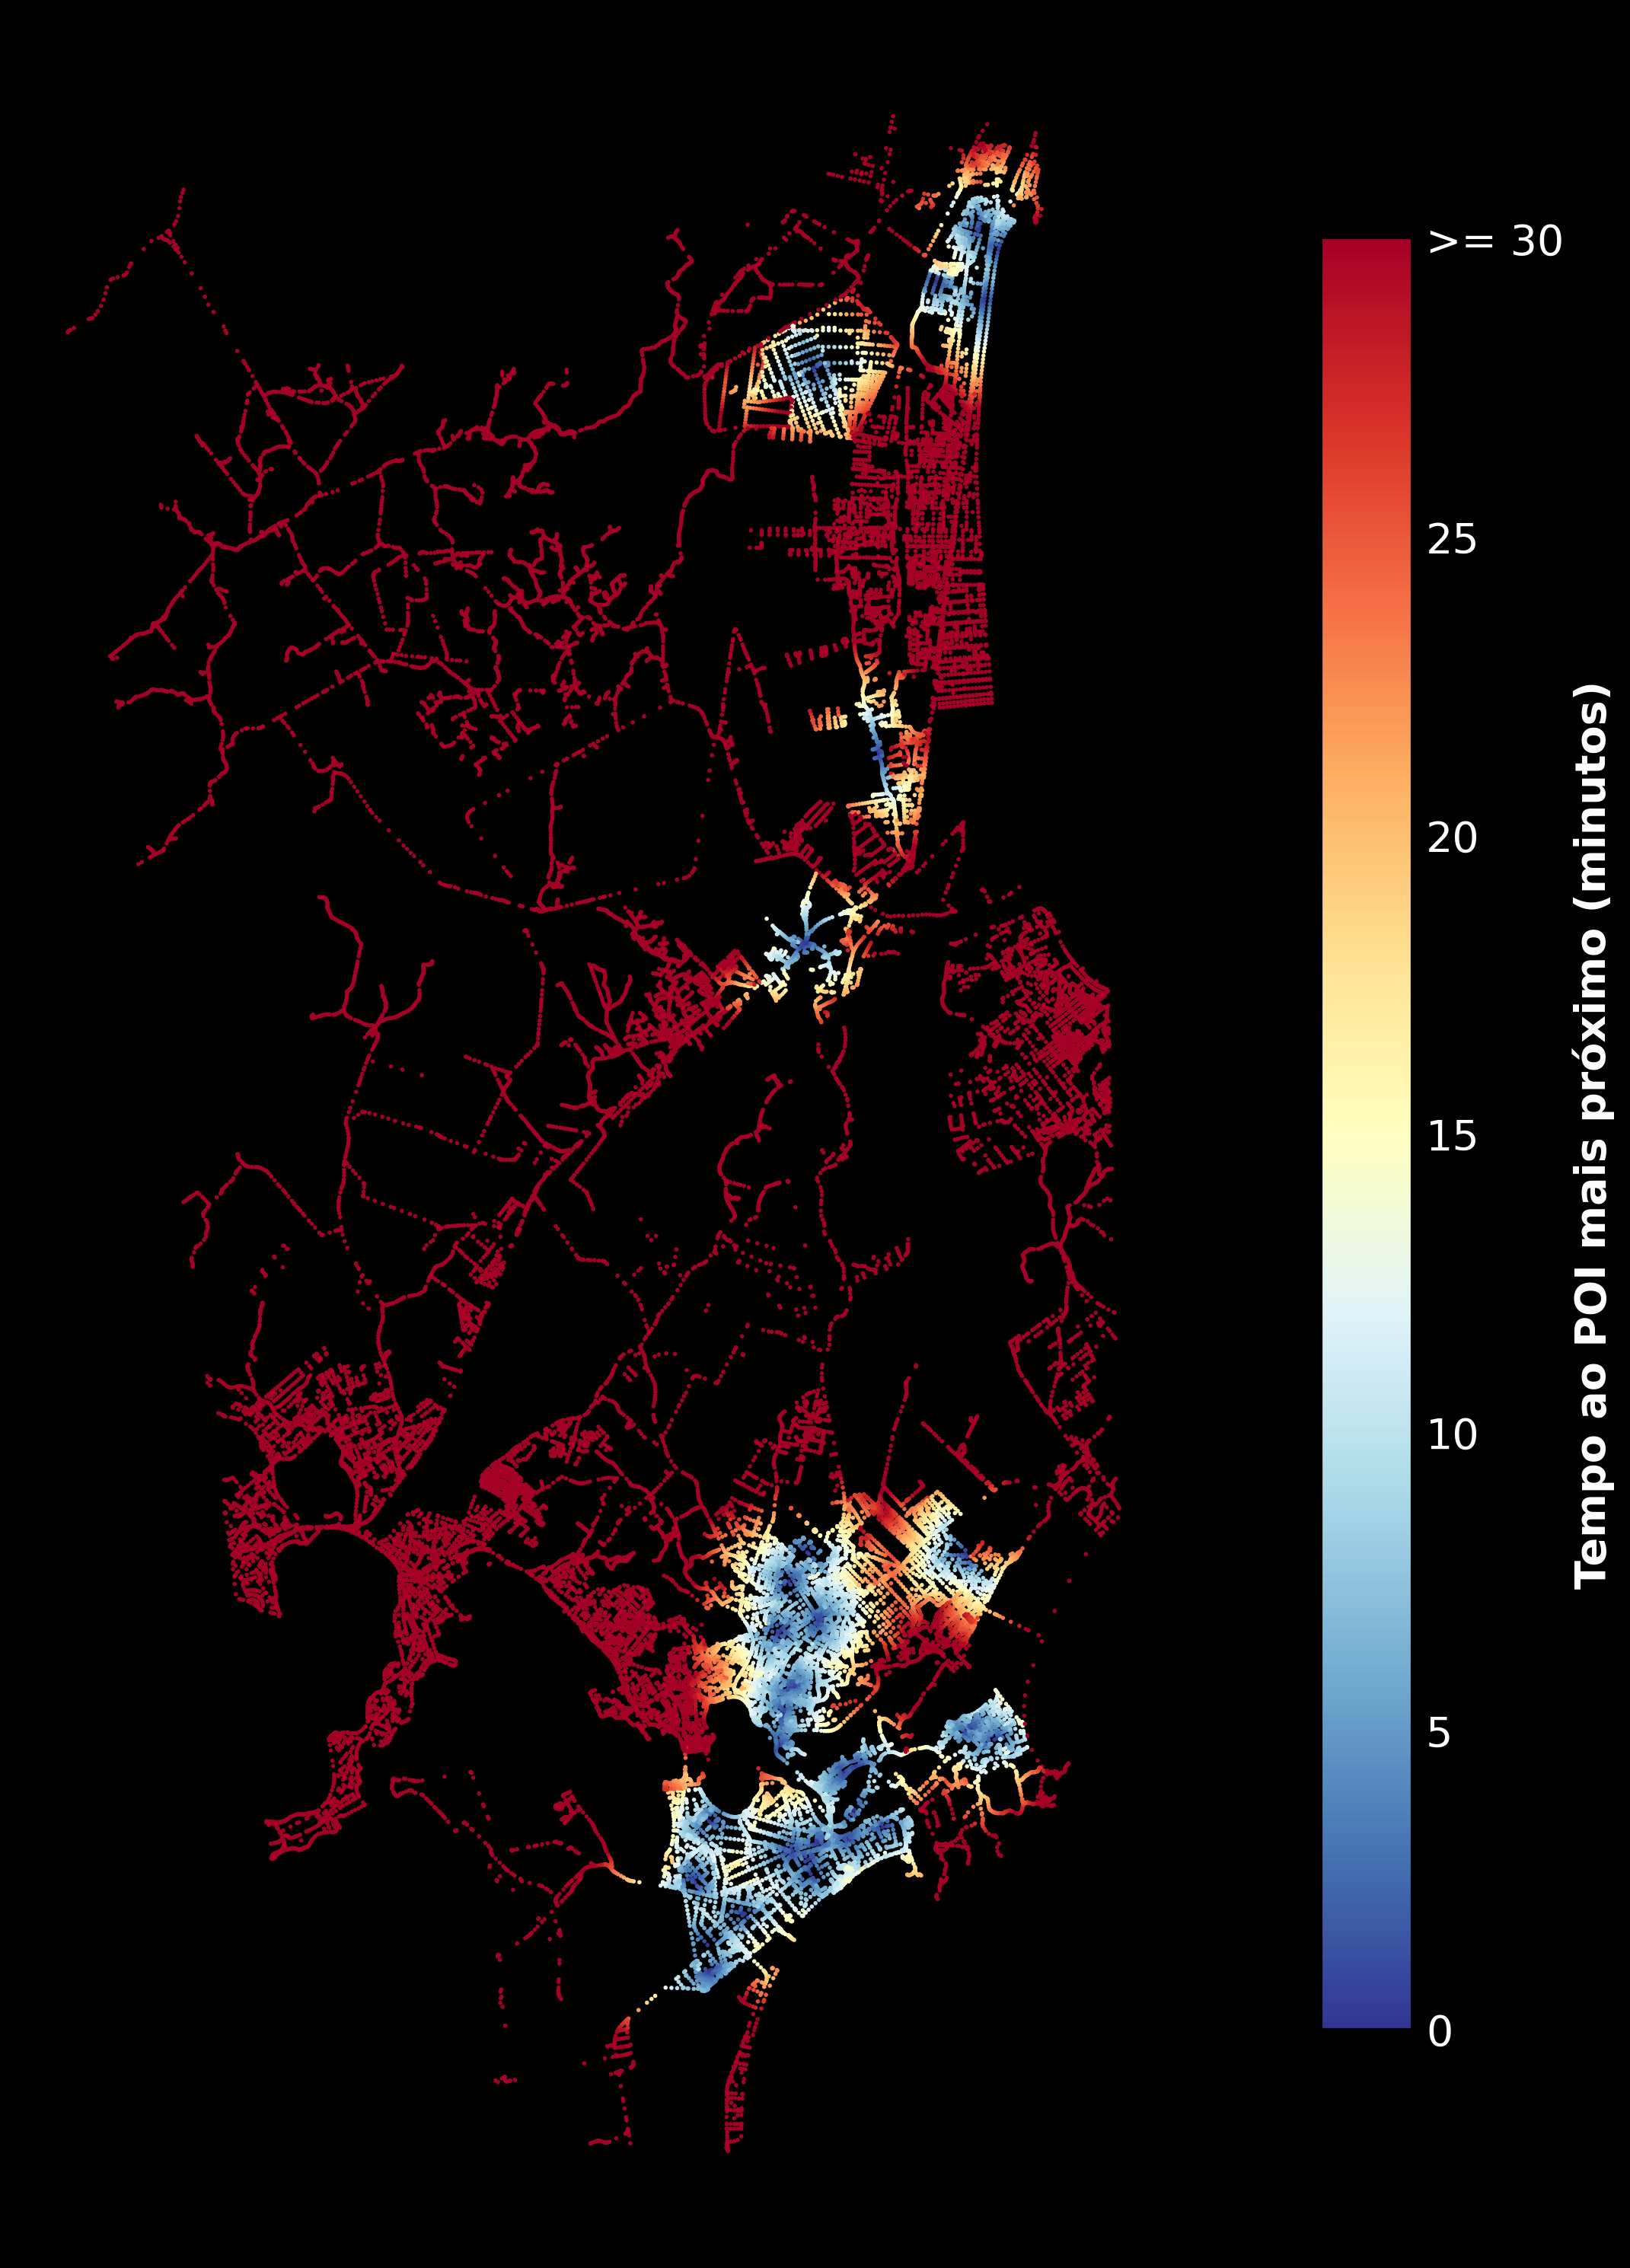

In [21]:
# Set text parameters
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

# Setup plot
fig, ax = plt.subplots(figsize=(20,15))
ax.set_axis_off()
ax.set_aspect('equal')
fig.set_facecolor((0,0,0))

# Plot distance to nearest POI
sc = ax.scatter(
    x=nodes['x'],
    y=nodes['y'], 
    c=distances[1],
    s=1,
    cmap='RdYlBu_r',
)

# Colorbar
def ranged_labels(max_val, min_val=0, step=5):
    labels = [
        v for v in range(min_val, max_val, step)
        ]
    if not labels or labels[-1] < max_val:
        labels.append(max_val)

    return labels


def format_labels(nums):
    return [str(n) for n in nums[:-1]] + [f'>= {nums[-1]}'] if nums else []
    

cb = fig.colorbar(
    sc, ax=ax, shrink=0.8,
    ticks=[
        t * 60 # Dados em segundos, tempo máx. viagem, minutos
        for t
        in ranged_labels(tempo_maximo_viagem)
        ]
    )
cb.ax.tick_params(color='none', labelsize=20)
cb.ax.set_yticklabels(
    format_labels(
        ranged_labels(tempo_maximo_viagem)
        )
    )
cb.set_label('Tempo ao POI mais próximo (minutos)', fontsize=20, fontweight='bold')

# Remove empty space
plt.tight_layout()

plt.show()

## Gráficos